In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = "data/synpop_related"
seed_data = pd.read_csv(os.path.join(data_folder, 'pp_sample_ipu.csv'))
seed_data = seed_data.drop(columns=["serialno", "sample_geog"])
seed_data

,age,sex,relationship,persinc,nolicence,anywork
0,50-59,M,Main,$1000-1249 p.w.,Some Licence,Y
1,40-49,F,Spouse,$1-199 p.w.,Some Licence,N
2,10-19,F,Child,Zero Income,No Licence,N
3,0-9,F,Child,Zero Income,No Licence,N
4,50-59,F,Parent,$1-199 p.w.,Some Licence,N
...,...,...,...,...,...,...
75404,60-69,F,Main,$400-599 p.w.,Some Licence,Y
75405,70-79,M,Main,$300-399 p.w.,Some Licence,N
75406,70-79,F,Spouse,$300-399 p.w.,Some Licence,N
75407,70-79,F,Main,$400-599 p.w.,Some Licence,N


In [3]:
saa_data = pd.read_csv(os.path.join(data_folder, 'SAA_PP_seed_test.csv'))
csp_data = pd.read_csv(os.path.join(data_folder, 'csp_results_run1.csv'))
ipu_data = pd.read_csv(os.path.join(data_folder, 'syn_pp_ipu.csv'))

In [4]:
pp_persinc_order = [
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]

In [5]:
check = {
    "IPU": ipu_data,
    # "SAA": saa_data,
    "CSP": csp_data,
    "VISTA": seed_data
}

In [17]:
def compare_rela(check_data, rela, attr):
    process_sub = {name: df[df["relationship"]==rela] for name, df in check_data.items()}
    if attr == "persinc":
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(pp_persinc_order) for name, df in process_sub.items()}
    elif attr == "age":
        expected_order = list(sorted(seed_data[attr].unique()))
        expected_order.remove("100+")
        expected_order.append("100+")
        process_sub = {name: df[attr].value_counts(normalize=True).reindex(expected_order) for name, df in process_sub.items()}
    else:
        process_sub = {name: df[attr].value_counts(normalize=True).sort_index() for name, df in process_sub.items()}

    pd.DataFrame(process_sub).plot(kind="bar", figsize=(10, 6), title=f"Comparison of {rela} {attr} distribution")

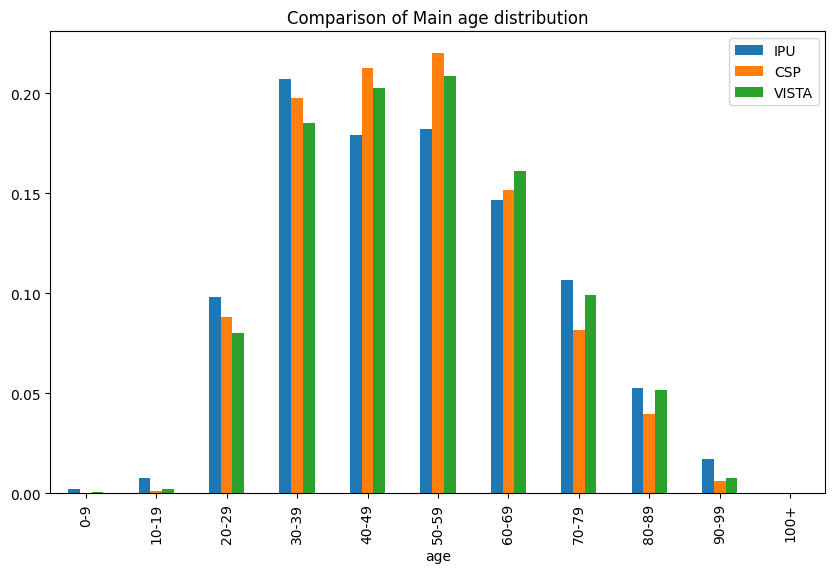

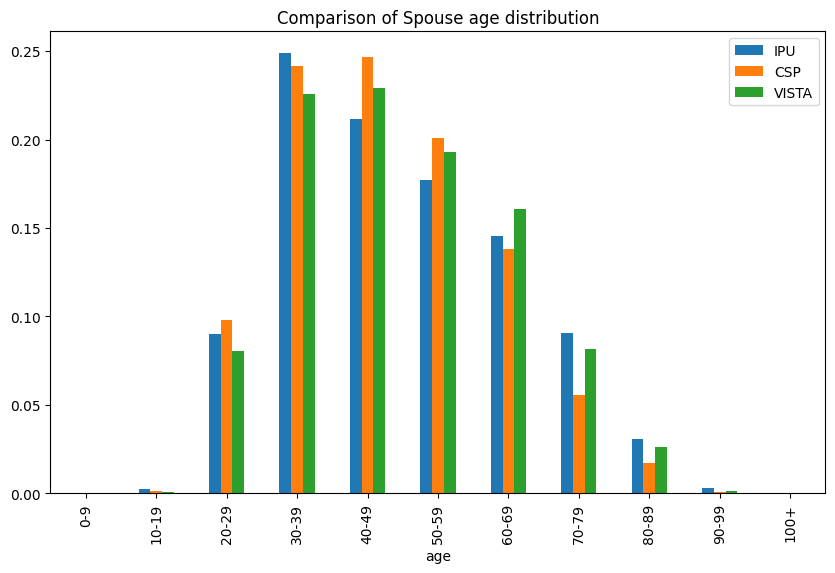

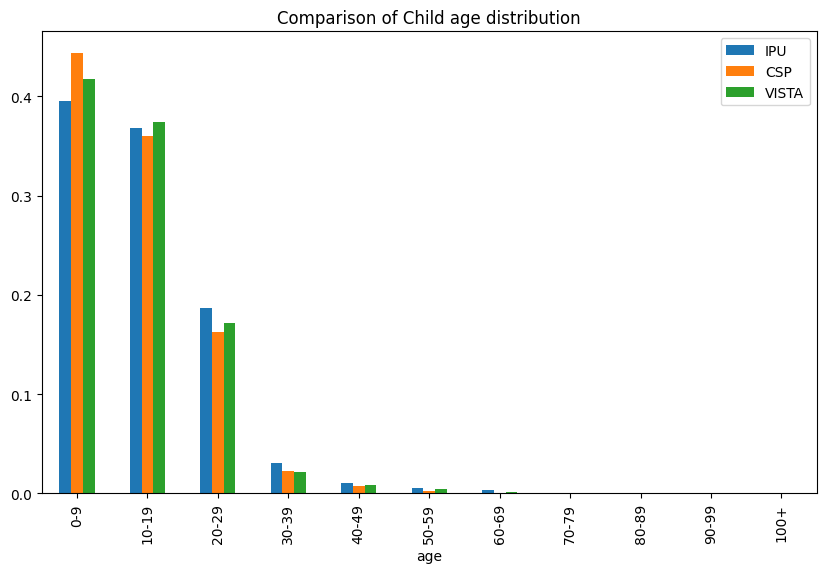

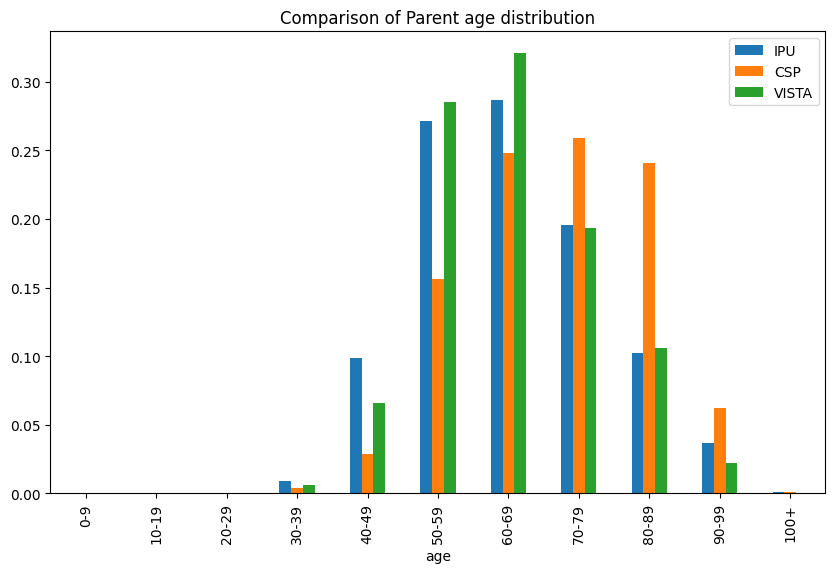

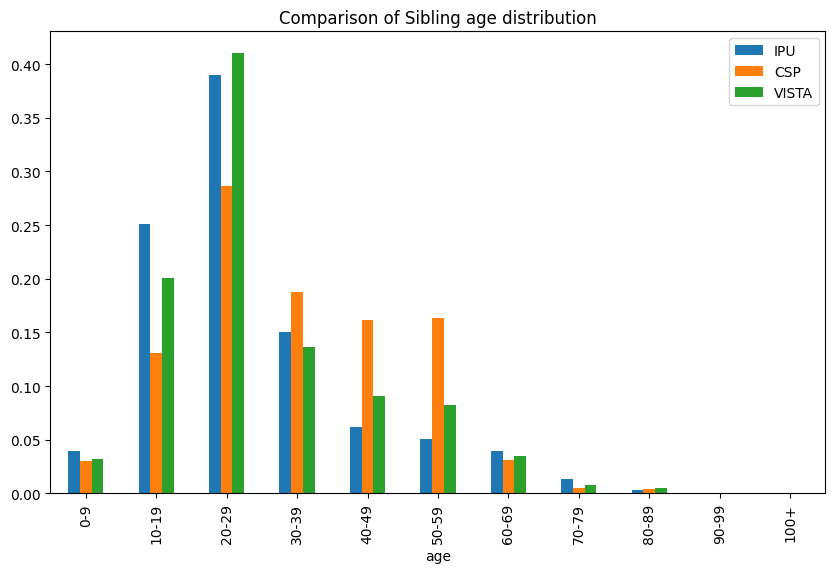

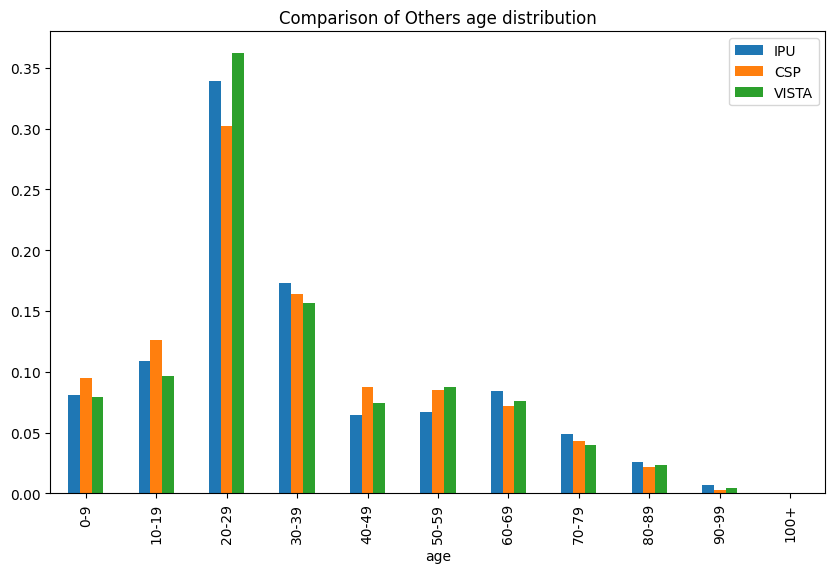

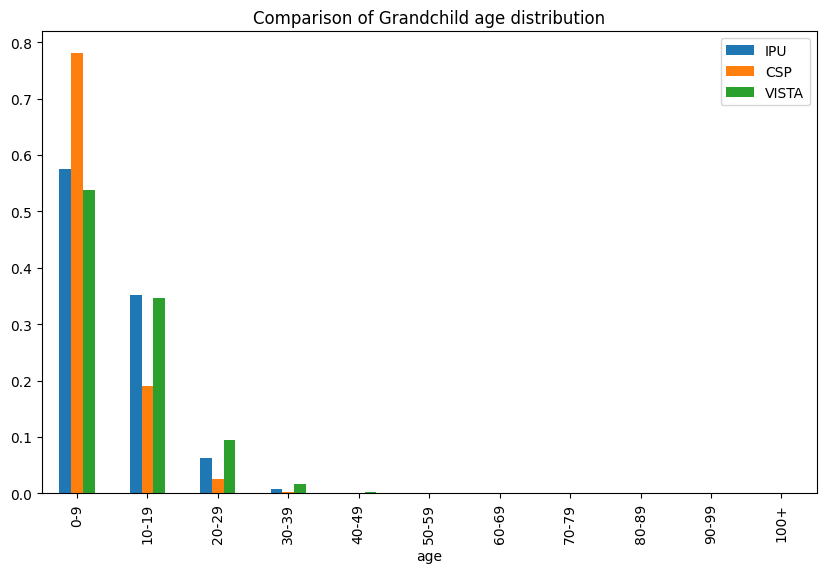

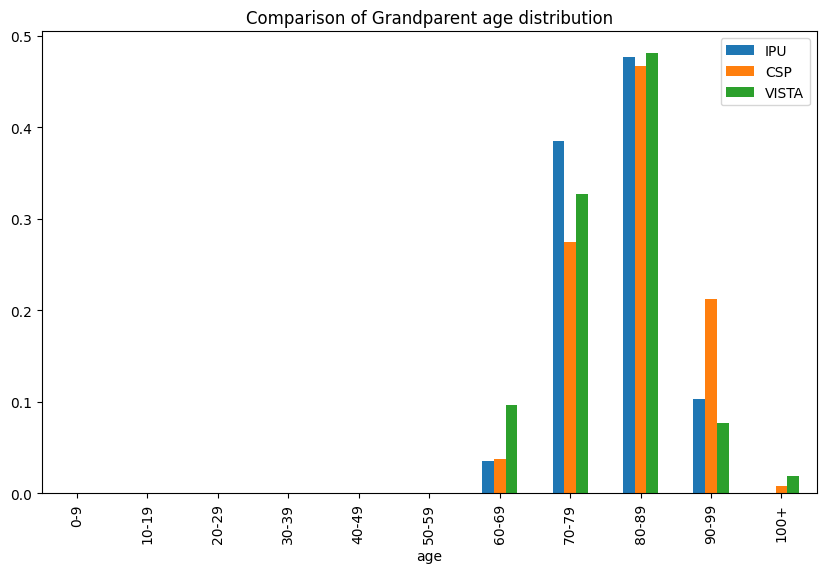

In [18]:
for rela in seed_data["relationship"].unique():
    compare_rela(check, rela, "age")
    plt.show()